In [205]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings

In [225]:
warnings.filterwarnings('ignore')

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [208]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=None)

Loading the data on to tensors (cpu)

In [209]:
train_data_tensor = torch.ones(()).new_empty((60000,784))
test_data_tensor = torch.ones(()).new_empty((10000,784))
for i in range(60000):
    train_data_tensor[i] = torch.tensor(np.array(train_data[i][0]).reshape(784,))
for i in range(10000):
    test_data_tensor[i] = torch.tensor(np.array(test_data[i][0]).reshape(784,))
train_data_tensor = train_data_tensor.T
test_data_tensor = test_data_tensor.T

In [210]:
train_data_tensor.shape,test_data_tensor.shape

(torch.Size([784, 60000]), torch.Size([784, 10000]))

Converting the labels to one hot encoding

In [211]:
train_labels = torch.zeros((60000,10))
test_labels = torch.zeros((10000,10))
for i in range(60000):
    train_labels[i][train_data[i][1]] = 1
for i in range(10000):
    test_labels[i][test_data[i][1]] = 1

In [212]:
train_labels = train_labels.T
test_labels = test_labels.T

In [213]:
train_data_tensor = train_data_tensor.to(torch.float64)
train_labels = train_labels.to(torch.float64)
test_data_tensor = test_data_tensor.to(torch.float64)
test_labels = test_labels.to(torch.float64)

Defining useful functions

In [214]:
#some useful activation function
def sigmoid(z):
    return 1/(1+np.exp(-z))
def relu(z):
    z[z<0] = 0
    return z
def tanh(z):
    z = np.exp(-2*z)
    z = 2/(1+z)-1
    return z
def softmax(z):
    x = np.exp(z)
    sums = torch.sum(x,axis = 0)
    for i in range(len(sums)):
        x[:,i] = x[:,i]/sums[i]
    return x
def linear(z):
    return z

In [215]:
def mse(y_pred,y_true):
    loss = (y_pred-y_true)**2
    loss = torch.sum(loss,axis=0)/y_pred.shape[1]
    return loss

In [216]:
def cross_entropy_loss(y_pred, y_true):
    loss = -torch.sum(y_true*np.log(y_pred),axis = 1)
    loss = torch.sum(loss, axis=0)
    return loss

$$
a^{(l+1)}=f(z^{(l+1)}) \newline
z^{(l+1)} = w^{(l)}a^{(l)}+b^{(l)}
$$

In [217]:
#defining one forward pass
def one_forward_pass(a,W,b):
    z_new = torch.mm(W,a)
    z_new = z_new + b
    return z_new

In [218]:
def test2():
    return 69
def test1(x,yo):
    print(test2==yo)
    return 3

In [219]:
def df(z,act):
    if(act==sigmoid):
        a = sigmoid(z)
        temp_a = a**2
        return temp_a*np.exp(-z)
    elif(act==tanh):
        a = tanh(z)
        return 1-a**2
    elif(act==relu):
        a = relu(z)
        a[a>=0] = 1
        a[a<0] = 0
        return a
#     return z*(1-z)

In [220]:
def class_report(final_pred, test_labels):
    s = classification_report(final_pred.T, test_labels.T)
    line = ""
    for i in s:
        if(i!='\n'):
            line = line + i
        else:
            print(line)
            line = ""
    print(line)

$$
w_1 \rightarrow 500 \times 784 \newline
w_2 \rightarrow 250 \times 500 \newline
w_3 \rightarrow 100 \times 250 \newline
w_4 \rightarrow 10 \times 100 \newline
$$

$$
Architecture: \newline
I \backslash P \rightarrow h_{1}(500) \rightarrow h_{2}(250) \rightarrow h_{3}(100) \rightarrow O \backslash P
$$

In [221]:
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
    def __len__(self):
        return self.data_tensor.shape[1]

    def __getitem__(self, idx):
        x = self.data_tensor[:,idx]
        y = self.target_tensor[:,idx]
        return x,y

In [222]:
def train_network(act, lamda=0.0001, epochs=15, batch_size = 64):
    it = 1
    loss = []
    count = 0


    m1 = (6/(500+784))**0.5
    w1 = np.random.uniform(-m1, m1, 500*784).reshape(500,784)

    m2 = (6/(250+500))**0.5
    w2 = np.random.uniform(-m2,m2, 250*500).reshape(250,500)

    m3 = (6/(100+250))**0.5
    w3 = np.random.uniform(-m3,m3,100*250).reshape(100,250)

    m4 = (6/(10+100))**0.5
    w4 = np.random.uniform(-m4,m4,10*100).reshape(10,100)

    w1 = torch.tensor(w1)
    w2 = torch.tensor(w2)
    w3 = torch.tensor(w3)
    w4 = torch.tensor(w4)

    #initializing the bias vectors
    b1 = torch.zeros((500,1))
    b2 = torch.zeros((250,1))
    b3 = torch.zeros((100,1))
    b4 = torch.zeros((10,1))
    
    print("Initialization done")
    while(it<=epochs):
        print("| === Epoch: ",it," === |")
        s = "| === Epoch: "+str(it)+" === |"
        it = it + 1
        custom_dataset = CustomTensorDataset(train_data_tensor, train_labels)
        dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
        for batch in dataloader:
            count = count+1
            x = batch[0].T
            y_true = batch[1].T

            a1 = x

            z2 = one_forward_pass( a1,w1,b1)
            a2 = act(z2)

            z3 = one_forward_pass(a2,w2,b2)
            a3 = act(z3)

            z4 = one_forward_pass(a3,w3,b3)
            a4 = act(z4)

            z5  = one_forward_pass(a4,w4,b4)
            a5 = z5
            y = softmax(a5)

            delta5 = -(y_true - y)*(1)             # f'(Z5)=1 since f(z5)=z5

            delta4 = torch.mm(w4.T,delta5)*df(z4,act)   # f'(z4)=a4^2*e(-z4)

            delta3 = torch.mm(w3.T,delta4)*df(z3,act)

            delta2 = torch.mm(w2.T,delta3)*df(z2,act)

            dw4 = torch.mm(delta5, a4.T)
            dw3 = torch.mm(delta4, a3.T)
            dw2 = torch.mm(delta3, a2.T)
            dw1 = torch.mm(delta2, a1.T)

            w4 = w4 - lamda*dw4
            w3 = w3 - lamda*dw3
            w2 = w2 - lamda*dw2
            w1 = w1 - lamda*dw1
            b4 = b4 - lamda*torch.sum(delta5,axis=1).reshape(b4.shape)
            b3 = b3 - lamda*torch.sum(delta4,axis=1).reshape(b3.shape)
            b2 = b2 - lamda*torch.sum(delta3,axis=1).reshape(b2.shape)
            b1 = b1 - lamda*torch.sum(delta2,axis=1).reshape(b1.shape)

            new_loss = cross_entropy_loss(y, y_true)
            #loss.append(new_loss)
            if(count%200==0):
                loss.append(new_loss)
                #print(count," Batches are done")
    print("Training the neural network successfully done.")
    plt.figure(figsize=(20,10))
    plt.plot(loss[2:])
    plt.xlabel('Number of Batches/Iterations',fontdict={'fontsize':16})
    plt.ylabel('Cross entropy loss',fontdict={'fontsize':16})
    plt.title('Loss vs t',fontdict={'fontsize':18})
    plt.show()
    W=[w1,w2,w3,w4,b1,b2,b3,b4]
    return loss, W

In [223]:
#testing:
def model_predict(train_data_tensor, W):
    x = train_data_tensor

    a1 = x
    w1, w2, w3, w4 = W[0], W[1], W[2], W[3]
    b1, b2, b3, b4 = W[4], W[5], W[6], W[7]
    z2 = one_forward_pass( a1,w1,b1)
    a2 = sigmoid(z2)

    z3 = one_forward_pass(a2,w2,b2)
    a3 = sigmoid(z3)

    z4 = one_forward_pass(a3,w3,b3)
    a4 = sigmoid(z4)

    z5  = one_forward_pass(a4,w4,b4)
    a5 = z5
    y = softmax(a5)
    max_index = y.max(axis=0)[1]
    n = y.shape[1]
    y_pred = torch.zeros((10,n))
    for i in range(n):
        y_pred[max_index[i],i] = 1
    del y
    return y_pred

In [224]:
def accuracy(y_pred, y_true, flag=1):
    if(flag==1):
        count = 0
        n = y_pred.shape[1]
        for i in range(n):
            if(sum(y_pred[:,i]==y_true[:,i])==10):
                count = count + 1
        percent = count/n*100
        print("Accuracy = ", round(percent,2),"%")
        class_report(final_pred, test_labels)
        return round(percent,2)
    else:
        count = 0
        n = y_pred.shape[1]
        for i in range(n):
            if(sum(y_pred[:,i]==y_true[:,i])==10):
                count = count + 1
        percent = count/n*100
        print("Accuracy = ", round(percent,2),"%")
        return round(percent,2)

=== The baseline model with given hyperparameters ====

Initialization done
| === Epoch:  1  === |


C:\Users\HP\AppData\Local\Temp\ipykernel_23968\913289398.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))
C:\Users\HP\AppData\Local\Temp\ipykernel_23968\345029572.py:5: RuntimeWarning: overflow encountered in exp
  return temp_a*np.exp(-z)


| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |
Training the neural network successfully done.


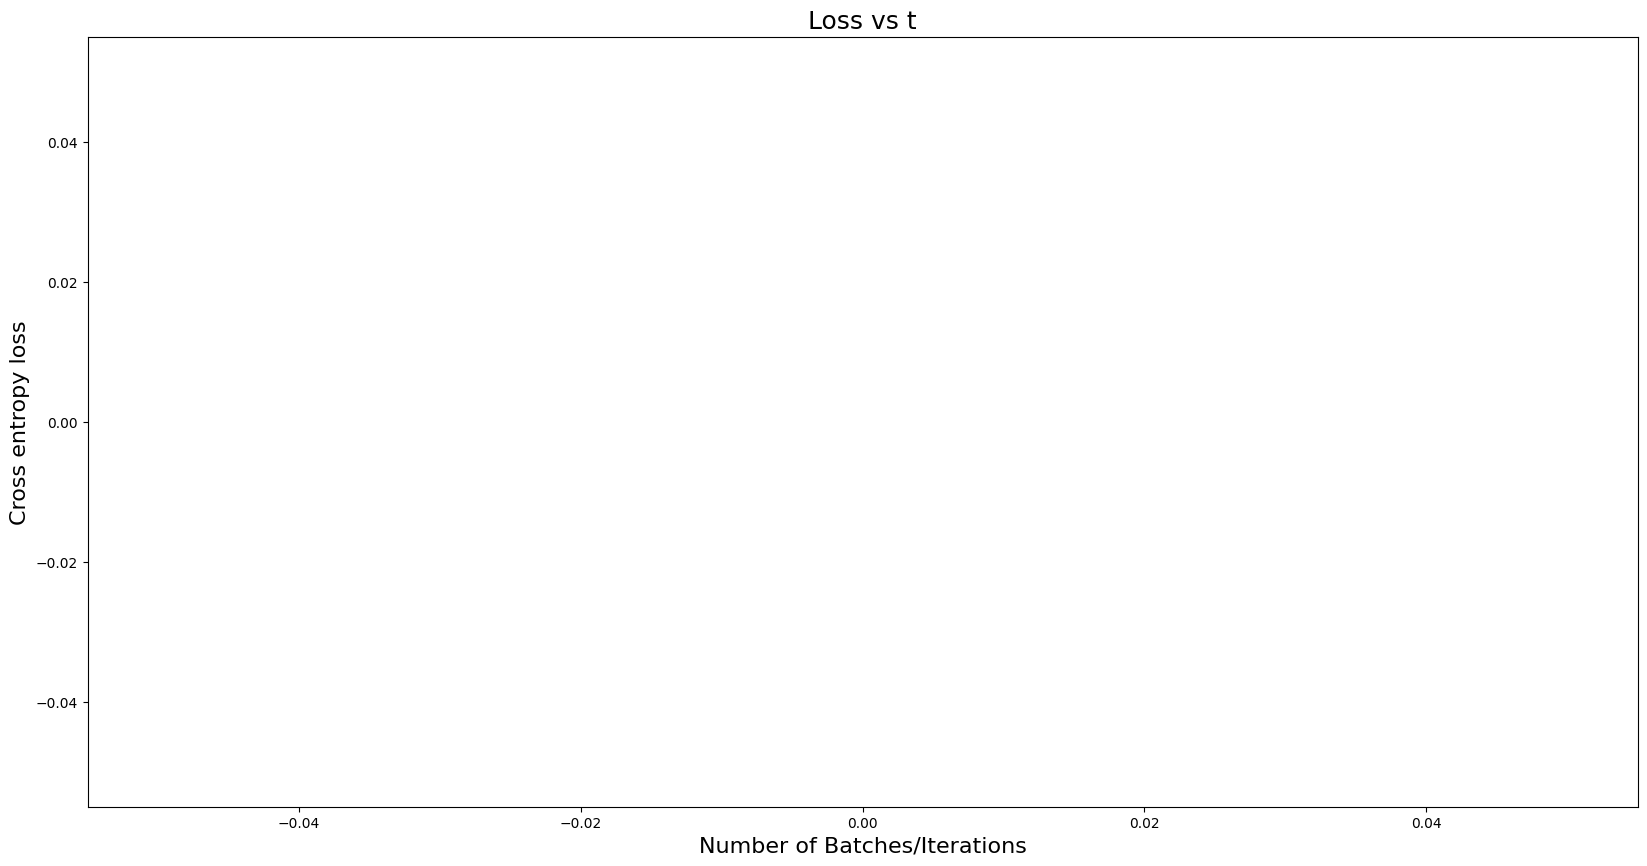

In [195]:
loss, W = train_network(sigmoid, lamda=0.01, batch_size=64)

As we can see from with the given hyperparameters the model will not converge
In other words it is not learning at all, because the values blowup.

In [196]:
#accuracy on the train dataset
y_pred = model_predict(train_data_tensor,W)
_ = accuracy(y_pred, train_labels)

Accuracy =  9.87 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [197]:
#validation
test_data_tensor = test_data_tensor.cpu()
y_pred = model_predict(test_data_tensor.to(float), W)
_ = accuracy(y_pred, test_labels)

Accuracy =  9.8 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see from with the given hyperparameters the model will not converge<br>In other words it is not learning at all, because the values blowup. <br> 

 ==========                      ==================              ============


After few experiments it is found that for learning_rate = 0.001 the model converges and the accuracy is very high.<br>
<br>
<br>
Below is the network with updated parameters

====Sigmoid====

In [174]:
train_data_tensor = train_data_tensor.cpu()
test_data_tensor = test_data_tensor.cpu()

Initialization done
| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |
Training the neural network successfully done.


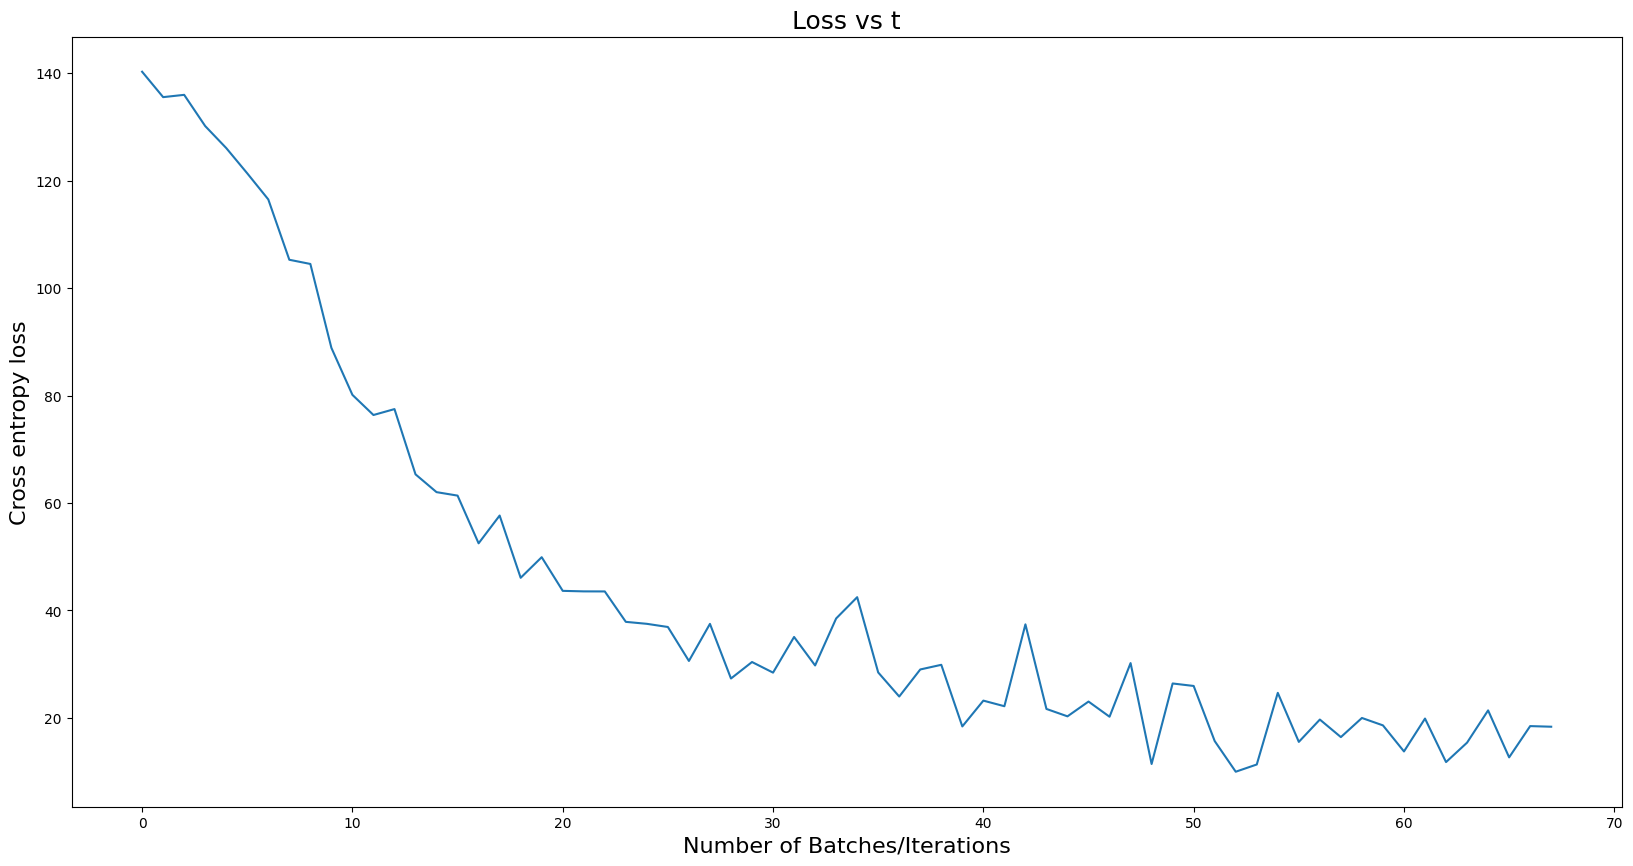

In [227]:
loss, W = train_network(sigmoid, lamda=0.0001, batch_size=64)

In [228]:
y_pred = model_predict(train_data_tensor,W)
_ = accuracy(y_pred, train_labels)

Accuracy =  93.35 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



In [229]:
y_pred = model_predict(test_data_tensor.to(float), W)
_ = accuracy(y_pred, test_labels)

Accuracy =  92.49 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



===========Pytorch implementation===========<br>

In [133]:
class Network(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim,act):
        super(Network, self).__init__()
        # self.relu = torch.nn.ReLU()
        #self.act = torch.nn.Sigmoid()
        # self.tanh = torch.nn.Tanh()
        #self.softmax = torch.nn.Softmax(dim=1)
        self.a1 = nn.Linear(input_dim, h1)
        self.a2 = nn.Linear(h1,h2)
        self.a3 = nn.Linear(h2,h3)
        self.a4 = nn.Linear(h3,output_dim)
        #self.activation = torch.nn.Sigmoid()
        if(act=='Sigmoid'):
            self.activation = torch.nn.Sigmoid()
        elif(act=='ReLU'):
            self.activation = torch.nn.ReLU()
        elif(act=='Tanh'):
            self.activation = torch.nn.ReLU()
    def forward(self, x):
        x = self.a1(x)
        x = self.activation(x)

        x = self.a2(x)
        x = self.activation(x)


        x = self.a3(x)
        x = self.activation(x)


        x = self.a4(x)
        #x = nn.Softmax(x, dim=1)
        temp = torch.nn.Softmax(dim=1)
        x = temp(x)

        return x



In [143]:
def train_network_torch(epochs=15,act='Sigmoid', regularization='No', alpha = 1e-5):
    store_loss = []
    model = Network(input_size, h1, h2, h3, output_size, act).to(device)
    criterion = nn.CrossEntropyLoss()
    if(regularization=='L2'):
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = alpha)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    for i in range(epochs):
        print("| === Epoch: ",i+1," === |")
        epoch_loss= []
        custom_dataset = CustomTensorDataset(train_data_tensor, train_labels)
        dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
        for batch in dataloader:
            x = batch[0]
            y = batch[1]
            x = x.to(torch.float32)
            y = y.to(torch.float32)
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            #loss = F.nll_loss(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        store_loss.append(sum(epoch_loss)/len(epoch_loss))
    plt.plot(store_loss)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Cross entroly Loss')
    plt.title('Loss vs t')
    plt.show()
    return model

In [140]:
def test_network_torch(model):
    with torch.no_grad():
        global test_data_tensor, train_data_tensor
        train_data_tensor = train_data_tensor.to(torch.float32)
        train_data_tensor = train_data_tensor.to(device)
        train_pred = model(train_data_tensor.T)
        train_pred = train_pred.T
        train_pred = train_pred.to(device)
        max_train = train_pred.max(axis=0)[1]
        n1 = train_pred.shape[1]
        final_train_pred = torch.zeros((10,n1))
        for i in range(n1):
            final_train_pred[max_train[i],i] = 1
        print("Below is the accuracy for training data")
        _ = accuracy(final_train_pred, train_labels, flag=0)

        test_data_tensor = test_data_tensor.to(torch.float32)
        test_data_tensor = test_data_tensor.to(device)
        pred_y = model(test_data_tensor.T)
        pred_y = pred_y.T
        pred_y = pred_y.to(device)
        max_index = pred_y.max(axis=0)[1]
        n = pred_y.shape[1]
        final_pred = torch.zeros((10,n))
        for i in range(n):
            final_pred[max_index[i],i] = 1
        #print(final_pred.shape,test_labels.shape)
        print("Below is the accuracy for testing data")
        _ = accuracy(final_pred, test_labels)
        return _

Running the baseline model with given hyperparameters

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |


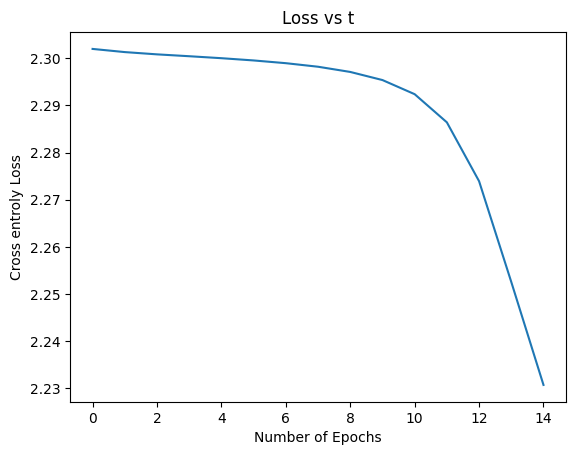

Below is the accuracy for training data
Accuracy =  29.68 %
Below is the accuracy for testing data
Accuracy =  29.65 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


29.65

In [141]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.01
batch_size = 64
model = train_network_torch(epochs=15,act='Sigmoid')
test_network_torch(model)

Comments:<br>
The baseline parameters are not optimal.

After experimenting with different values of below are the best hyperparameters, which maximizes accuracy

======Sigmoid==============

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |


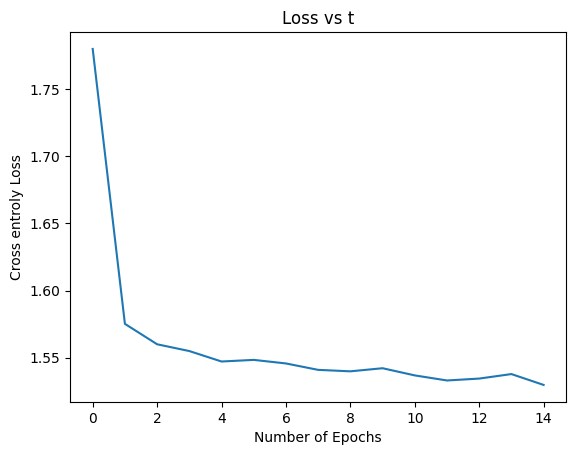

Below is the accuracy for training data
Accuracy =  93.93 %
Below is the accuracy for testing data
Accuracy =  93.81 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


93.81

In [148]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.001
batch_size = 100
model = train_network_torch(epochs=15,act='Sigmoid')
test_network_torch(model)

============ReLU============

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |


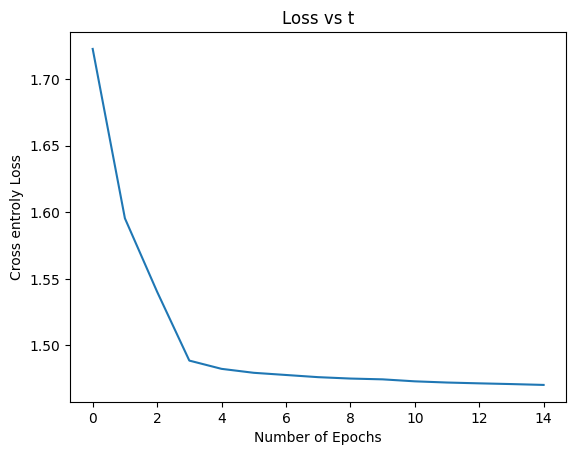

Below is the accuracy for training data
Accuracy =  99.16 %
Below is the accuracy for testing data
Accuracy =  97.73 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97.73

In [156]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.0001
batch_size = 64

model = train_network_torch(epochs=15,act='ReLU')
test_network_torch(model)

========Tanh===============

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |


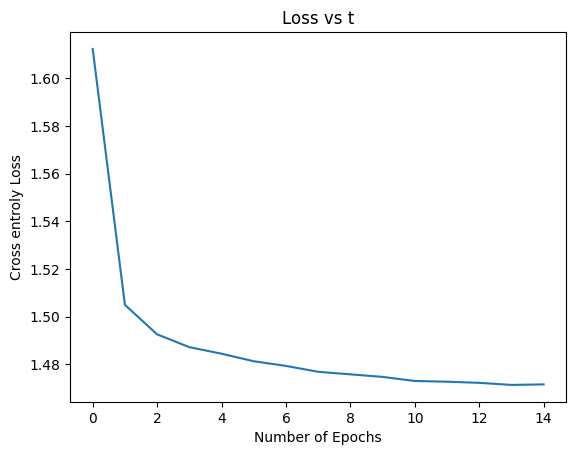

Below is the accuracy for training data
Accuracy =  98.77 %
Below is the accuracy for testing data
Accuracy =  97.47 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97.47

In [157]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.0001
batch_size = 64
model = train_network_torch(epochs=15,act='Tanh')
test_network_torch(model)

======With L2 Regularization======

L2 regularization with sigmoid activation

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |


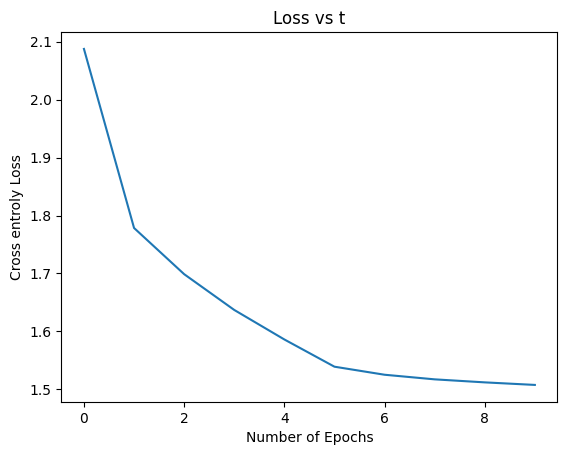

Below is the accuracy for training data
Accuracy =  96.61 %
Below is the accuracy for testing data
Accuracy =  95.71 %


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



95.71

In [158]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.0001
batch_size = 64
model = train_network_torch(epochs=10,act='Sigmoid',regularization='L2', alpha=1e-4)
test_network_torch(model)

L2 regularization with ReLU activation

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |


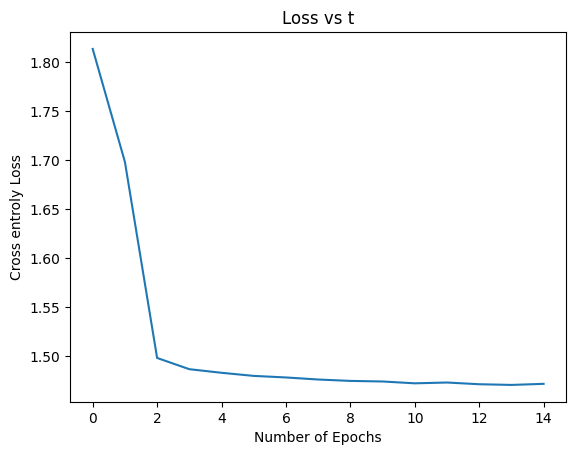

Below is the accuracy for training data
Accuracy =  98.89 %
Below is the accuracy for testing data
Accuracy =  97.25 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97.25

In [159]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.0001
batch_size = 64

model = train_network_torch(epochs=15,act='ReLU',regularization='L2', alpha=1e-4)
test_network_torch(model)

L2 regularization with Tanh activation

| === Epoch:  1  === |
| === Epoch:  2  === |
| === Epoch:  3  === |
| === Epoch:  4  === |
| === Epoch:  5  === |
| === Epoch:  6  === |
| === Epoch:  7  === |
| === Epoch:  8  === |
| === Epoch:  9  === |
| === Epoch:  10  === |
| === Epoch:  11  === |
| === Epoch:  12  === |
| === Epoch:  13  === |
| === Epoch:  14  === |
| === Epoch:  15  === |


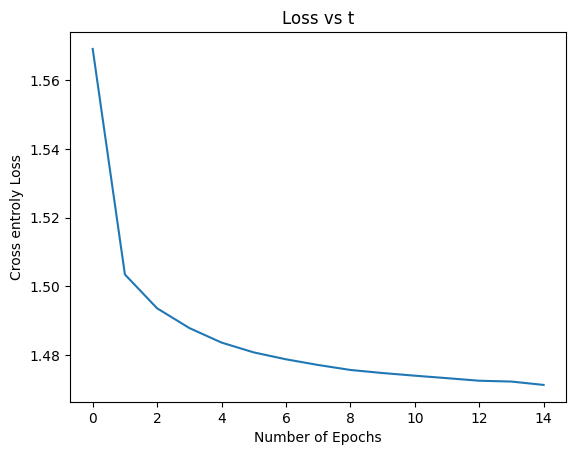

Below is the accuracy for training data
Accuracy =  99.35 %
Below is the accuracy for testing data
Accuracy =  98.08 %
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      1191
           1       0.98      0.92      0.95      1208
           2       0.00      0.00      0.00         0
           3       0.94      0.60      0.73      1567
           4       0.92      0.84      0.88      1066
           5       0.00      0.00      0.00         0
           6       0.97      0.79      0.87      1176
           7       0.91      0.91      0.91      1030
           8       0.93      0.53      0.67      1720
           9       0.88      0.85      0.86      1042

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.75      0.62      0.68     10000
weighted avg       0.94      0.76      0.83     10000
 samples avg       0.76      0.76      0.76     10000



C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98.08

In [161]:
input_size = 784
h1 = 500
h2 = 250
h3 = 100
output_size = 10
learning_rate = 0.0001
batch_size = 64
model = train_network_torch(epochs=15,act='Tanh',regularization='L2', alpha=1e-3)
test_network_torch(model)

Comments:<br>
After regularization the model accuracy increased with L2 regularization indicating that model generalized well.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Lin_Reg.ipynb"
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Lin_Reg.ipynb"